In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import kagglehub
import ast

# Preparing Dataset

In this step we will turn the dataset from something like this:

|   | title | ingredients | directions | link | NER | site|
| - | ----- | ----------- | ---------- | ---- | - | - |
| 0 | 'Recipe 1' | '["1 small jar chipped beef", "1 c. peanut butter"]' | '["step 1", "step 2"]' |'link' | '["beef", "peanute butter"]' | 'link' |
| 1 | 'Recipe 2' | '["1/2 vanilla", "a cup of milk"]' | '["step 1", "step 2"]' |'link' | '["vanilla", "milk"]' | 'link' |

to something like this

|   | sentence | tag         |
| - | -------- | ----------- |
| 0 | 'Mix peanut butter to the bowl' | ['O', 'B-FOOD', 'I-FOOD', 'O', 'O', 'O'] |
| 1 | 'Stir vanilla and milk; mix well' | ['O', 'B-FOOD', 'O', 'B-FOOD', 'O', 'O'] |

In [ ]:
# Download latest version
path = kagglehub.dataset_download("wilmerarltstrmberg/recipe-dataset-over-2m")

data = pd.read_csv(path+'/recipes_data.csv')
data.head()

100%|██████████| 635M/635M [00:06<00:00, 96.3MB/s]

Extracting files...


,title,ingredients,directions,link,source,NER,site
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""bite size shredded rice biscuits"", ""vanilla""...",www.cookbooks.com
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""cream of mushroom soup"", ""beef"", ""sour cream...",www.cookbooks.com
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""pepper"", ""cream cheese"", ""gar...",www.cookbooks.com
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken gravy"", ""cream of mushroom soup"", ""c...",www.cookbooks.com
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""graham cracker crumbs"", ""powdered sugar"", ""p...",www.cookbooks.com


In [ ]:
def text2list(text):
    """
    text: '["milk", "butter"]'
    list: ['milk', 'butter']
    """
    return ast.literal_eval(text)

def keyword2tag(keyword):
    """
    keyword: 'bite size shredded rice biscuits'
    tag: ['B-FOOD', 'I-FOOD', 'I-FOOD', 'I-FOOD', 'I-FOOD']
    """
    words = keyword.split()
    tag = []
    for i in range(len(words)):
        if i == 0:
            tag.append('B-FOOD')
        else:
            tag.append('I-FOOD')
    return tag

def keywords2tags(keywords):
    """
    keywords: ['vanilla', 'brown sugar', 'milk']
    tags: [['B-FOOD'], ['B-FOOD', 'I-FOOD'], ['B-FOOD']]
    """
    tags = list(map(keyword2tag, keywords))
    return tags


# test function
ingredients = text2list(data['NER'][0])
ingredients_tags = keywords2tags(ingredients)
for i in range(len(ingredients)):
    print(ingredients[i], ingredients_tags[i])

bite size shredded rice biscuits ['B-FOOD', 'I-FOOD', 'I-FOOD', 'I-FOOD', 'I-FOOD']
vanilla ['B-FOOD']
brown sugar ['B-FOOD', 'I-FOOD']
nuts ['B-FOOD']
milk ['B-FOOD']
butter ['B-FOOD']


In [ ]:
#df_pre = data[:20].copy()[['directions', 'NER']] # prototype
df_pre = data.copy()[['directions', 'NER']][:5000] #uncomment to use larger dataset

df_pre['NER'] = df_pre['NER'].apply(text2list)
df_pre['directions'] = df_pre['directions'].apply(text2list)
df_pre.head()

,directions,NER
0,"[In a heavy 2-quart saucepan, mix brown sugar,...","[bite size shredded rice biscuits, vanilla, br..."
1,"[Place chipped beef on bottom of baking dish.,...","[cream of mushroom soup, beef, sour cream, chi..."
2,"[In a slow cooker, combine all ingredients. Co...","[frozen corn, pepper, cream cheese, garlic pow..."
3,"[Boil and debone chicken., Put bite size piece...","[chicken gravy, cream of mushroom soup, chicke..."
4,[Combine first four ingredients and press in 1...,"[graham cracker crumbs, powdered sugar, peanut..."


In [ ]:
import string

tag2id = {'O': 0, 'B-FOOD': 1, 'I-FOOD': 2}

def remove_punctuation(text):
    trans = str.maketrans('', '', string.punctuation)
    text = text.translate(trans)
    return text

def text2tags(text, ingredients, ingredients_tags):
    """
    text: 'Stir in vanilla and milk; mix well.'
    tags: [O O B-FOOD O B-FOOD O O]
    """
    # Preprocess text (remove punctuation, etc)
    #text = text.replace('-', ' ').replace('_', ' ') # ex: 2-quarts -> 2 quarts, instead of 2quarts
    # remove punctuation
    text = remove_punctuation(text)

    # turn: "Stir in vanilla and brown sugar; mix well"
    # to  : "Stir in B-FOOD and B-FOOD I-FOOD mix well"
    for i in range(len(ingredients)):
        text = text.replace(ingredients[i], " ".join(ingredients_tags[i]))

    tags = [word if word in tag2id else 'O' for word in text.split()]
    return tags

def texts2tags(texts, ingredients, ingredients_tags):
    """
    texts: ['Boil and stir 5 minutes more. Take off heat.',
            'Stir in vanilla and brown sugar; mix well',]
    tags: [[O O O O O O O O O], [O O B-FOOD O B-FOOD I-FOOD O O]]
    """
    return [text2tags(text, ingredients, ingredients_tags) for text in texts]


texts2tags(['Boil and stir 5 minutes more. Take off heat.',
            'Stir in vanilla and brown sugar; mix well.'],
          ingredients, ingredients_tags)

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'B-FOOD', 'O', 'B-FOOD', 'I-FOOD', 'O', 'O']]

In [ ]:
def create_tag_column(row):
    ingredients = row['NER']
    ingredients_tags = keywords2tags(ingredients)
    texts = row['directions']

    return texts2tags(texts, ingredients, ingredients_tags)

def create_df_flatten(df):
    df['tag'] = df.apply(create_tag_column, axis=1)

    df_flatten = pd.DataFrame({
        'sentence': [sentence for sentences in df['directions'] for sentence in sentences],
        'tag': [tag for tags in df['tag'] for tag in tags]
    })
    return df_flatten

# this dataframe should be converted to csv
df_flatten = create_df_flatten(df_pre)
df_flatten.head()

,sentence,tag
0,"In a heavy 2-quart saucepan, mix brown sugar, ...","[O, O, O, O, O, O, B-FOOD, I-FOOD, B-FOOD, O, ..."
1,Stir over medium heat until mixture bubbles al...,"[O, O, O, O, O, O, O, O, O, O]"
2,Boil and stir 5 minutes more. Take off heat.,"[O, O, O, O, O, O, O, O, O]"
3,Stir in vanilla and cereal; mix well.,"[O, O, B-FOOD, O, O, O, O]"
4,"Using 2 teaspoons, drop and shape into 30 clus...","[O, O, O, O, O, O, O, O, O, O, O, O]"


# Preprocess

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_flatten, test_size=0.2, shuffle=False)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_flatten['sentence'])

word2id = tokenizer.word_index
id2word = dict([(id, word) for word, id in word2id.items()])

id2tag = dict([(id, tag) for tag, id in tag2id.items()])

# To prevent data mismatch
# sometimes the original texts_to_sequences ommits characters we don't want to ommit
def sentences2sequences(sentences):
    sequences = []
    for sentence in sentences:
        words = remove_punctuation(sentence).split()
        sequence = [word2id[word] if word in word2id else 0 for word in words]
        sequences.append(sequence)
    return sequences

def tags2sequences(tags_lists):
    sequences = []
    for tags in tags_lists:
        sequence = [tag2id[tag] for tag in tags]
        sequences.append(sequence)
    return sequences

# reverse a sequence to a sentence
def sequence2sentence(sequence):
    sentence = ""
    for i in sequence:
        if i in id2word:
            sentence += id2word[i] + " "
    return sentence.strip()

In [ ]:
x_train = sentences2sequences(df_train['sentence'].values.tolist())
y_train = tags2sequences(df_train['tag'].values.tolist())
x_val = sentences2sequences(df_val['sentence'].values.tolist())
y_val = tags2sequences(df_val['tag'].values.tolist())

print("x_train sequence sample: ", x_train[0])
print("y_train sequence sample: ", y_train[0])

x_train sequence sample:  [0, 8, 374, 0, 123, 9, 45, 20, 94, 682, 47, 1, 30, 22, 97]
y_train sequence sample:  [0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0]


In [ ]:
# Pad
maxlen = max(len(seq) for seq in y_train+y_val)
print("maxlen:", maxlen)

X_train = pad_sequences(x_train, maxlen=maxlen, padding="post")
Y_train = pad_sequences(y_train, maxlen=maxlen, padding="post")
X_val = pad_sequences(x_val, maxlen=maxlen, padding="post")
Y_val = pad_sequences(y_val, maxlen=maxlen, padding="post")

maxlen: 137


In [ ]:
BATCH_SIZE = len(X_train)//10 + (len(X_train) % 10 > 10) # 10% of X_train, and round it up

ds_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
ds_train = ds_train.batch(BATCH_SIZE)
ds_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
ds_val = ds_val.batch(BATCH_SIZE)

# Model

In [ ]:
VOCAB_SIZE = len(word2id)+1
LATENT_DIM = 300
NUM_CLASS = len(tag2id)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(maxlen,)),
    tf.keras.layers.Embedding(VOCAB_SIZE, LATENT_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
    tf.keras.layers.Dense(NUM_CLASS, activation="softmax")
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 137, 300)            │       1,058,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 137, 200)            │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 137, 3)              │             603 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,380,103 (5.26 MB)

 Trainable params: 1,380,103 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(ds_train,
                    epochs=15,
                    validation_data=ds_val
                   )

Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.7361 - loss: 0.3176 - val_accuracy: 0.9938 - val_loss: 0.0214
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 312ms/step - accuracy: 0.9936 - loss: 0.0214 - val_accuracy: 0.9938 - val_loss: 0.0180
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.9936 - loss: 0.0179 - val_accuracy: 0.9946 - val_loss: 0.0152
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 320ms/step - accuracy: 0.9947 - loss: 0.0153 - val_accuracy: 0.9955 - val_loss: 0.0130
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.9954 - loss: 0.0133 - val_accuracy: 0.9960 - val_loss: 0.0115
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.9959 - loss: 0.0119 - val_accuracy: 0.9963 - val_loss: 0.0105
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 323ms/step - accuracy: 0.9961 - loss: 0.0108 - val_accuracy: 0.9964 - val_loss: 0.0096
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.9963 - loss: 0.0100 - val_accuracy: 0.

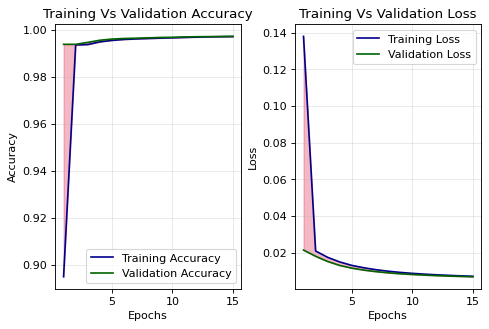

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 4), dpi=80)

ax[0].plot(epochs, acc, label = "Training Accuracy", color='darkblue')
ax[0].plot(epochs, val_acc, label = "Validation Accuracy", color='darkgreen')
ax[0].grid(alpha=0.3)
ax[0].title.set_text('Training Vs Validation Accuracy')
ax[0].fill_between(epochs, acc, val_acc, color='crimson', alpha=0.3)
ax[0].legend()
plt.setp(ax[0], xlabel='Epochs')
plt.setp(ax[0], ylabel='Accuracy')


ax[1].plot(epochs, loss, label = "Training Loss", color='darkblue')
ax[1].plot(epochs, val_loss, label = "Validation Loss", color='darkgreen')
ax[1].grid(alpha=0.3)
ax[1].title.set_text('Training Vs Validation Loss')
ax[1].fill_between(epochs,loss, val_loss, color='crimson', alpha=0.3)
ax[1].legend()
plt.setp(ax[1], xlabel='Epochs')
plt.setp(ax[1], ylabel='Loss')

plt.show()

# Predict

In [ ]:
def print_predict(text, model):
    sequence = sentences2sequences([text])
    sequence = pad_sequences(sequence, maxlen=maxlen, padding="post")
    predictions = np.argmax(model.predict(sequence), axis=-1)[0]
    words = remove_punctuation(text).split()

    print("Ingredients detected in the sentence:")
    ingredients = [words[i] for i, tagid in enumerate(predictions) if tagid > 0]
    print(ingredients)

#print_predict(df_flatten['sentence'][0], model)
print_predict("Give me recipe of chicken, egg, pepper", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Ingredients detected in the sentence:
['chicken', 'egg', 'pepper']


# Eval

In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=30697aa6865e9a0b40dfe18d4e8979bf0a5cd2a6040f239b7926acac42a080d1
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
from seqeval.metrics import classification_report

def sequences2tags(sequences):
    tags_lists = []
    for sequence in sequences:
        tags = []
        for id in sequence:
            tags.append(id2tag[id])
        tags_lists.append(tags)
    return tags_lists

predictions = np.argmax(model.predict(X_val), axis=-1)
Y_true = sequences2tags(Y_val)
Y_pred = sequences2tags(predictions)

print(classification_report(Y_true, Y_pred))

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

        FOOD       0.68      0.75      0.71      3569

   micro avg       0.68      0.75      0.71      3569
   macro avg       0.68      0.75      0.71      3569
weighted avg       0.68      0.75      0.71      3569



# Save Model

In [ ]:
#model_path = 'model.keras'
model.save('model.h5')